<a href="https://colab.research.google.com/github/aandreigg/AACMM2023/blob/testing/AACMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimización de la medición mediante el uso de una red neuronal. 

**Objetivo: Generar una serie de coordenadas de posibles posiciones del brazo de medición para luego aplicar los parámetros de Denavit-Hartenberg y obtener las coordenadas espaciales del brazo robótico. Estos servirán como partida de entrada para entrenar a la red convolucional y así ajustar los hiperparámetros de la red neuronal.**

Para correr este notebook de Jupyter es necesario instalar las siguientes dos paqueterias necesarias para la interfaz y las redes neuronales. 

**1. Instalar Pygame para la interfaz y representacion grafica. Para su instalacion abrir la terminal de comandos de anaconda e ingresar la siguiente instruccion.**

"pip install Pygame==2.1.2"



**2. Instalar Tensorflow, la libreria agrega las herramientas necesarias para no empezar desde cero la red neuronal y simplemente se ajustan los hiperparametros para su funcionamiento. Para la instalacion, abrir la terminal de comandos de anaconda e ingresar las siguientes instrucciones. Nota: Esta version de Tensorflow es CPU only , para la version GPU enabled buscar en la pagina oficial otro tutorial.** 

"pip install --ignore-installed --upgrade tensorflow==2.10.0" La version mas actual. 






In [1]:
#---------------------IMPORTACION DE LIBRERIAS----------------------------
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from keras import metrics
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import pygame as pg
import random as r
import math as m
from math import exp
#-------------------------------------------------------------------------
print(tf.__version__)

ModuleNotFoundError: ignored

In [ ]:
#-------------------GENERACION DE COORDENADAS Y MODELADO DE LA RED NEURONAL
'''clc;                                       #Codigo generado para OCTAVE/MATLAB. Calculo de coordenadas Denavit-Hartenberg
clear all;
a(1)=500;
a(2)=700;
a(3)=0;

theta(1)=pi/4;
theta(2)=0;
theta(3)=0;


d(1)=d(2)=d(3)=0;
alpha(1)=a1pha(2)=alpha(3)=0;

Pant=[0;0;0;1];
%La matriz de power point tiene mal un signo
i=3;
while (i>0)
  A=[cos(theta(i)), -cos(alpha(i))*sin(theta(i)) , sin(alpha(i))*sin(theta(i)), a(i)*cos(theta(i));
   sin(theta(i)), cos(alpha(i))*cos(theta(i)), -sin(alpha(i))*cos(theta(i)), a(i)*sin(theta(i));
   0, sin(alpha(i)), cos(alpha(i)), d(i);
   0, 0, 0, 1];
   Pant=A*Pant;
   i--;
 endwhile
 disp(Pant(1:3));'''

#a[0]=500
#a[1]=700   #Valores de ejemplo, DOF es 3. Con estos valores el resultado debería ser [1200,0,0,1]
#theta[0]=m.pi/4


#-------------------INICIALIZACION DE VARIABLES-------------------------------

cloud_number = 10000 #Numero de posiciones para la red neuronal. 
DH_dataset = np.zeros((cloud_number,9), dtype = np.float64) #print(DH_dataset)
#-------------------------------------------------Variables Denavit-Hartenberg 

DOF = 6 #Degrees of freedom o grados de libertad del robot. 
a = np.zeros(DOF,dtype=np.float64)
d = np.zeros(DOF,dtype=np.float64)
alpha = np.zeros(DOF,dtype=np.float64)
theta = np.zeros(DOF,dtype=np.float64)
k= 0 

#-------------------------------------------------------------------------
#SUPONIENDO QUE LOS PARÁMETROS DENAVIT-HARTENBERG ESTÉN BIEN. 

a[1]=62
a[3]=62
d[0]=376
d[2]=751
d[4]=500
d[5]=15
alpha[0]=-m.pi/2 # Valores en radianes. (En este caso -90°)
alpha[1]=-m.pi/2
alpha[2]=-m.pi/2
alpha[3]=-m.pi/2
alpha[4]=-m.pi/2
alpha[5]= m.pi/2
l=98 #Dimension del punto final 


#--------------------------------------------------------------------------
#Creacion de la nube de posiciones de Tetha con sus respectivas coordenadas. 



for i in range(cloud_number): #Simulando los rangos de operación de las articulaciones. 
    cxyz = np.array([[0],[0],[l],[1]])
    k=0
    DH_dataset[i][0]= r.uniform(0,6.283) 
    theta[0] = DH_dataset[i][0]
    DH_dataset[i][1]=r.uniform(0,6.283) 
    theta[1] = DH_dataset[i][1]
    DH_dataset[i][2]=r.uniform(0,6.283) 
    theta[2] = DH_dataset[i][2]
    DH_dataset[i][3]=r.uniform(0,6.283) 
    theta[3] = DH_dataset[i][3]
    DH_dataset[i][4]=r.uniform(0,6.283) 
    theta[4] = DH_dataset[i][4]
    DH_dataset[i][5]=r.uniform(0,6.283) 
    theta[5] = DH_dataset[i][5]
    
    #print(DH_dataset) # Para ver como se hace el llenado del array con valores pseudoaleatorios.
        
        
#--------------Calculo de coordenadas usando algoritmo Denavit - Hartenberg

#TDH=0    
#+-----------------+----------------------------------+----------------------------------+----------------------+
#| m.cos(theta[k]) | -m.cos(alpha[k])*m.sin(theta[k]) | m.sin(alpha[k])*m.sin(theta[k])  | a[k]*m.cos(theta[k]) |
#+-----------------+----------------------------------+----------------------------------+----------------------+
#| m.sin(theta[k]) | m.cos(alpha[k])*m.cos(theta[k])  | -m.sin(alpha[k])*m.cos(theta[k]) | a[k]*m.sin(theta[k]) |
#+-----------------+----------------------------------+----------------------------------+----------------------+
#| 0               | m.sin(alpha[k])                  | m.cos(alpha[k])                  | d[k]                 |
#+-----------------+----------------------------------+----------------------------------+----------------------+
#| 0               | 0                                | 0                                | 1                    |
#+-----------------+----------------------------------+----------------------------------+----------------------+ 
#                                                                                                         TDH=15
    while(k<=DOF-1): # El orden de multiplicacion de las matrices si afecta el producto. 
        TDH = np.zeros(16,dtype=np.float64)
        TDH[0] = m.cos(theta[k])
        TDH[1] = -m.cos(alpha[k])*m.sin(theta[k])
        TDH[2] = m.sin(alpha[k])*m.sin(theta[k])
        TDH[3] = a[k]*m.cos(theta[k])
        TDH[4] = m.sin(theta[k])
        TDH[5] = m.cos(alpha[k])*m.cos(theta[k])
        TDH[6] = -m.sin(alpha[k])*m.cos(theta[k])
        TDH[7] = a[k]*m.sin(theta[k])
        TDH[8] = 0
        TDH[9] = m.sin(alpha[k])
        TDH[10]= m.cos(alpha[k])
        TDH[11]= d[k]
        TDH[12]= 0
        TDH[13]= 0
        TDH[14]= 0
        TDH[15]= 1
        #Se acomoda de esta forma la matriz para poder emplear el comando ".dot" de numpy.
        TDH = TDH.reshape(4,4)
        cxyz = np.dot(TDH,cxyz)
        k+=1
          

    DH_dataset[i][6] = cxyz[0]
    DH_dataset[i][7] = cxyz[1]
    DH_dataset[i][8] = cxyz[2] #print(cxyz)
      

#plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(cloud_number):
    ax.scatter(DH_dataset[i][6],DH_dataset[i][7],DH_dataset[i][8], c='red')


DH_dataset = pd.DataFrame(DH_dataset, columns = ['T1','T2','T3','T4','T5','T6','X1','Y2','Z3']) #print(DH_dataset) 

#--------------------------------------------------------------------------

#                                  El dataframe resultante se compone de la siguiente forma. 
#+-----------------------------------------------------------+-----------------------------+
#| theta 1 | theta 2 | theta 3  | theta 4 |theta 5 | theta 6 | Coord X | Coord Y | Coord Z |
#+-----------------------------------------------------------+-----------------------------+

# saving the dataframe
DH_dataset.to_csv("output_1.csv")


#--------------------------------------------------------------Separacion en angulos y coordenadas finales.  
angles = list(DH_dataset.columns.values)
angles.remove('X1')
angles.remove('Y2')
angles.remove('Z3')
coord = list(DH_dataset.columns.values)
coord.remove('T1')
coord.remove('T2')
coord.remove('T3')
coord.remove('T4')
coord.remove('T5')
coord.remove('T6')
X = DH_dataset[angles]
Y = DH_dataset[coord]


# RED NEURONAL CON LIBRERÍA KERAS

In [ ]:
#### ---------------- MODELADO DE LA RED NEURONAL PARA LA ESTIMACION DE COORDENADAS---------------------------
epochs_num = 1500
batch =512
#----------------------------------------------------------Subdivision en grupos de entrenamiento y prueba.
X_train, X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.8, random_state=42)
#-------------------------------------------------------------- ARQUITECTURA DE LA RED NEURONAL PROPUESTA
#Creación de tensores. 
X_train = tf.constant(X_train)
Y_train = tf.constant(Y_train)
X_test = tf.constant(X_test)
Y_test = tf.constant(Y_test)
# Building a simple model.
#First attempt. 10 layers
model=tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(6,)),
    tf.keras.layers.Dense(360, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(360, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(360, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(360, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(360, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(360, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(360, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(360, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(360, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(360, activation='elu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(3),
])


model.summary()

keras.utils.plot_model(model=model, to_file="model.png", show_shapes = True, rankdir = "LR",dpi=96,show_layer_activations = True)
############################################################################### Compile the model
model.compile(optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01), loss=tf.keras.losses.mae, metrics=['accuracy'])
############################################################################### Training the model 
training = model.fit(X_train, Y_train, epochs=epochs_num, batch_size= batch)
#--------------------------------------------------------------------------
model.evaluate(X_test, Y_test,verbose = 1,batch_size=batch)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 360)               2520      
                                                                 
 dense_1 (Dense)             (None, 360)               129960    
                                                                 
 dense_2 (Dense)             (None, 360)               129960    
                                                                 
 dense_3 (Dense)             (None, 360)               129960    
                                                                 
 dense_4 (Dense)             (None, 360)               129960    
                                                                 
 dense_5 (Dense)             (None, 360)               129960    
                                                                 
 dense_6 (Dense)             (None, 360)               1

4/4 [==============================] - 0s 99ms/step - loss: 383.8752 - accuracy: 0.5530
Epoch 63/1500
4/4 [==============================] - 0s 113ms/step - loss: 392.5693 - accuracy: 0.5470
Epoch 64/1500
4/4 [==============================] - 0s 101ms/step - loss: 389.4908 - accuracy: 0.5390
Epoch 65/1500
4/4 [==============================] - 0s 99ms/step - loss: 376.8833 - accuracy: 0.5570
Epoch 66/1500
4/4 [==============================] - 0s 120ms/step - loss: 392.5330 - accuracy: 0.5455
Epoch 67/1500
4/4 [==============================] - 0s 110ms/step - loss: 360.7532 - accuracy: 0.5655
Epoch 68/1500
4/4 [==============================] - 0s 114ms/step - loss: 389.7066 - accuracy: 0.5395
Epoch 69/1500
4/4 [==============================] - 0s 123ms/step - loss: 382.3700 - accuracy: 0.5470
Epoch 70/1500
4/4 [==============================] - 0s 115ms/step - loss: 366.2802 - accuracy: 0.5625
Epoch 71/1500
4/4 [==============================] - 0s 110ms/step - loss: 378.6828 - acc

4/4 [==============================] - 1s 127ms/step - loss: 231.1953 - accuracy: 0.7460
Epoch 142/1500
4/4 [==============================] - 1s 183ms/step - loss: 230.3175 - accuracy: 0.7605
Epoch 143/1500
4/4 [==============================] - 1s 129ms/step - loss: 230.9459 - accuracy: 0.7590
Epoch 144/1500
4/4 [==============================] - 0s 124ms/step - loss: 232.2660 - accuracy: 0.7615
Epoch 145/1500
4/4 [==============================] - 1s 142ms/step - loss: 234.6967 - accuracy: 0.7555
Epoch 146/1500
4/4 [==============================] - 1s 131ms/step - loss: 215.8390 - accuracy: 0.7660
Epoch 147/1500
4/4 [==============================] - 0s 117ms/step - loss: 223.5355 - accuracy: 0.7640
Epoch 148/1500
4/4 [==============================] - 0s 102ms/step - loss: 216.1379 - accuracy: 0.7740
Epoch 149/1500
4/4 [==============================] - 0s 108ms/step - loss: 208.0081 - accuracy: 0.7835
Epoch 150/1500
4/4 [==============================] - 0s 107ms/step - loss: 226

4/4 [==============================] - 0s 108ms/step - loss: 153.1662 - accuracy: 0.8420
Epoch 221/1500
4/4 [==============================] - 0s 108ms/step - loss: 146.2147 - accuracy: 0.8505
Epoch 222/1500
4/4 [==============================] - 0s 102ms/step - loss: 164.8179 - accuracy: 0.8390
Epoch 223/1500
4/4 [==============================] - 0s 93ms/step - loss: 157.8163 - accuracy: 0.8510
Epoch 224/1500
4/4 [==============================] - 0s 98ms/step - loss: 158.9783 - accuracy: 0.8440
Epoch 225/1500
4/4 [==============================] - 0s 108ms/step - loss: 150.9148 - accuracy: 0.8540
Epoch 226/1500
4/4 [==============================] - 0s 94ms/step - loss: 152.6187 - accuracy: 0.8665
Epoch 227/1500
4/4 [==============================] - 0s 96ms/step - loss: 149.3445 - accuracy: 0.8505
Epoch 228/1500
4/4 [==============================] - 0s 95ms/step - loss: 156.7498 - accuracy: 0.8415
Epoch 229/1500
4/4 [==============================] - 0s 103ms/step - loss: 145.1890

4/4 [==============================] - 0s 99ms/step - loss: 120.9910 - accuracy: 0.8815
Epoch 300/1500
4/4 [==============================] - 0s 94ms/step - loss: 121.0242 - accuracy: 0.8915
Epoch 301/1500
4/4 [==============================] - 0s 94ms/step - loss: 121.1784 - accuracy: 0.8900
Epoch 302/1500
4/4 [==============================] - 0s 94ms/step - loss: 118.8169 - accuracy: 0.8915
Epoch 303/1500
4/4 [==============================] - 0s 90ms/step - loss: 115.9208 - accuracy: 0.8845
Epoch 304/1500
4/4 [==============================] - 0s 98ms/step - loss: 123.5789 - accuracy: 0.8905
Epoch 305/1500
4/4 [==============================] - 0s 93ms/step - loss: 117.9652 - accuracy: 0.8930
Epoch 306/1500
4/4 [==============================] - 0s 94ms/step - loss: 120.4049 - accuracy: 0.8930
Epoch 307/1500
4/4 [==============================] - 0s 99ms/step - loss: 117.1039 - accuracy: 0.8950
Epoch 308/1500
4/4 [==============================] - 0s 89ms/step - loss: 116.1904 - ac

4/4 [==============================] - 0s 109ms/step - loss: 104.4400 - accuracy: 0.9095
Epoch 379/1500
4/4 [==============================] - 0s 100ms/step - loss: 104.5017 - accuracy: 0.9235
Epoch 380/1500
4/4 [==============================] - 0s 97ms/step - loss: 102.3952 - accuracy: 0.9125
Epoch 381/1500
4/4 [==============================] - 0s 100ms/step - loss: 101.6262 - accuracy: 0.9175
Epoch 382/1500
4/4 [==============================] - 0s 98ms/step - loss: 99.6137 - accuracy: 0.9125
Epoch 383/1500
4/4 [==============================] - 0s 101ms/step - loss: 103.5531 - accuracy: 0.9145
Epoch 384/1500
4/4 [==============================] - 0s 102ms/step - loss: 104.3659 - accuracy: 0.9100
Epoch 385/1500
4/4 [==============================] - 0s 99ms/step - loss: 100.8152 - accuracy: 0.9135
Epoch 386/1500
4/4 [==============================] - 0s 102ms/step - loss: 100.2003 - accuracy: 0.9170
Epoch 387/1500
4/4 [==============================] - 0s 100ms/step - loss: 98.8521

4/4 [==============================] - 0s 103ms/step - loss: 85.7182 - accuracy: 0.9260
Epoch 458/1500
4/4 [==============================] - 0s 111ms/step - loss: 85.0051 - accuracy: 0.9335
Epoch 459/1500
4/4 [==============================] - 0s 101ms/step - loss: 86.6745 - accuracy: 0.9280
Epoch 460/1500
4/4 [==============================] - 0s 96ms/step - loss: 87.3974 - accuracy: 0.9365
Epoch 461/1500
4/4 [==============================] - 0s 106ms/step - loss: 85.5277 - accuracy: 0.9280
Epoch 462/1500
4/4 [==============================] - 0s 105ms/step - loss: 87.2125 - accuracy: 0.9245
Epoch 463/1500
4/4 [==============================] - 1s 131ms/step - loss: 86.5226 - accuracy: 0.9435
Epoch 464/1500
4/4 [==============================] - 0s 110ms/step - loss: 85.8398 - accuracy: 0.9315
Epoch 465/1500
4/4 [==============================] - 0s 105ms/step - loss: 84.3259 - accuracy: 0.9275
Epoch 466/1500
4/4 [==============================] - 0s 110ms/step - loss: 89.9787 - acc

4/4 [==============================] - 0s 99ms/step - loss: 80.4620 - accuracy: 0.9465
Epoch 537/1500
4/4 [==============================] - 0s 105ms/step - loss: 80.8490 - accuracy: 0.9385
Epoch 538/1500
4/4 [==============================] - 0s 94ms/step - loss: 81.4652 - accuracy: 0.9465
Epoch 539/1500
4/4 [==============================] - 0s 106ms/step - loss: 83.0414 - accuracy: 0.9420
Epoch 540/1500
4/4 [==============================] - 0s 104ms/step - loss: 81.4046 - accuracy: 0.9400
Epoch 541/1500
4/4 [==============================] - 0s 98ms/step - loss: 78.0788 - accuracy: 0.9545
Epoch 542/1500
4/4 [==============================] - 0s 100ms/step - loss: 80.2914 - accuracy: 0.9520
Epoch 543/1500
4/4 [==============================] - 0s 102ms/step - loss: 77.8119 - accuracy: 0.9450
Epoch 544/1500
4/4 [==============================] - 0s 95ms/step - loss: 78.0063 - accuracy: 0.9425
Epoch 545/1500
4/4 [==============================] - 0s 99ms/step - loss: 80.7475 - accurac

Epoch 616/1500
4/4 [==============================] - 0s 110ms/step - loss: 77.1713 - accuracy: 0.9415
Epoch 617/1500
4/4 [==============================] - 0s 94ms/step - loss: 76.9289 - accuracy: 0.9405
Epoch 618/1500
4/4 [==============================] - 0s 99ms/step - loss: 73.8432 - accuracy: 0.9415
Epoch 619/1500
4/4 [==============================] - 0s 105ms/step - loss: 75.4741 - accuracy: 0.9470
Epoch 620/1500
4/4 [==============================] - 0s 94ms/step - loss: 75.7243 - accuracy: 0.9470
Epoch 621/1500
4/4 [==============================] - 0s 103ms/step - loss: 75.6865 - accuracy: 0.9510
Epoch 622/1500
4/4 [==============================] - 0s 110ms/step - loss: 75.4799 - accuracy: 0.9445
Epoch 623/1500
4/4 [==============================] - 0s 106ms/step - loss: 74.4450 - accuracy: 0.9415
Epoch 624/1500
4/4 [==============================] - 0s 124ms/step - loss: 73.6313 - accuracy: 0.9510
Epoch 625/1500
4/4 [==============================] - 0s 99ms/step - loss: 7

4/4 [==============================] - 0s 117ms/step - loss: 68.3178 - accuracy: 0.9535
Epoch 696/1500
4/4 [==============================] - 0s 115ms/step - loss: 69.2256 - accuracy: 0.9620
Epoch 697/1500
4/4 [==============================] - 0s 106ms/step - loss: 69.3056 - accuracy: 0.9560
Epoch 698/1500
4/4 [==============================] - 0s 102ms/step - loss: 69.7657 - accuracy: 0.9505
Epoch 699/1500
4/4 [==============================] - 0s 95ms/step - loss: 71.6514 - accuracy: 0.9505
Epoch 700/1500
4/4 [==============================] - 0s 99ms/step - loss: 69.4612 - accuracy: 0.9555
Epoch 701/1500
4/4 [==============================] - 0s 99ms/step - loss: 66.3973 - accuracy: 0.9510
Epoch 702/1500
4/4 [==============================] - 0s 99ms/step - loss: 68.2229 - accuracy: 0.9535
Epoch 703/1500
4/4 [==============================] - 0s 110ms/step - loss: 67.4240 - accuracy: 0.9575
Epoch 704/1500
4/4 [==============================] - 0s 109ms/step - loss: 69.2260 - accura

4/4 [==============================] - 0s 108ms/step - loss: 66.2065 - accuracy: 0.9540
Epoch 775/1500
4/4 [==============================] - 0s 110ms/step - loss: 65.6092 - accuracy: 0.9610
Epoch 776/1500
4/4 [==============================] - 0s 96ms/step - loss: 64.8463 - accuracy: 0.9615
Epoch 777/1500
4/4 [==============================] - 0s 110ms/step - loss: 65.5685 - accuracy: 0.9565
Epoch 778/1500
4/4 [==============================] - 0s 104ms/step - loss: 67.0505 - accuracy: 0.9625
Epoch 779/1500
4/4 [==============================] - 0s 119ms/step - loss: 63.0363 - accuracy: 0.9625
Epoch 780/1500
4/4 [==============================] - 0s 120ms/step - loss: 66.3374 - accuracy: 0.9685
Epoch 781/1500
4/4 [==============================] - 0s 117ms/step - loss: 65.0092 - accuracy: 0.9705
Epoch 782/1500
4/4 [==============================] - 0s 122ms/step - loss: 64.6102 - accuracy: 0.9645
Epoch 783/1500
4/4 [==============================] - 0s 100ms/step - loss: 64.2253 - acc

4/4 [==============================] - 0s 111ms/step - loss: 61.7524 - accuracy: 0.9590
Epoch 854/1500
4/4 [==============================] - 1s 146ms/step - loss: 62.1830 - accuracy: 0.9615
Epoch 855/1500
4/4 [==============================] - 0s 113ms/step - loss: 62.1495 - accuracy: 0.9635
Epoch 856/1500
4/4 [==============================] - 0s 117ms/step - loss: 63.0062 - accuracy: 0.9650
Epoch 857/1500
4/4 [==============================] - 1s 130ms/step - loss: 62.7019 - accuracy: 0.9620
Epoch 858/1500
4/4 [==============================] - 0s 105ms/step - loss: 61.7014 - accuracy: 0.9635
Epoch 859/1500
4/4 [==============================] - 0s 101ms/step - loss: 63.5093 - accuracy: 0.9590
Epoch 860/1500
4/4 [==============================] - 0s 96ms/step - loss: 63.2250 - accuracy: 0.9630
Epoch 861/1500
4/4 [==============================] - 0s 104ms/step - loss: 62.0269 - accuracy: 0.9580
Epoch 862/1500
4/4 [==============================] - 0s 98ms/step - loss: 60.9893 - accu

4/4 [==============================] - 0s 112ms/step - loss: 60.6604 - accuracy: 0.9785
Epoch 933/1500
4/4 [==============================] - 0s 104ms/step - loss: 59.5296 - accuracy: 0.9805
Epoch 934/1500
4/4 [==============================] - 0s 97ms/step - loss: 58.6436 - accuracy: 0.9805
Epoch 935/1500
4/4 [==============================] - 0s 100ms/step - loss: 59.1191 - accuracy: 0.9780
Epoch 936/1500
4/4 [==============================] - 0s 95ms/step - loss: 58.7010 - accuracy: 0.9785
Epoch 937/1500
4/4 [==============================] - 0s 101ms/step - loss: 57.1573 - accuracy: 0.9820
Epoch 938/1500
4/4 [==============================] - 0s 102ms/step - loss: 58.0024 - accuracy: 0.9775
Epoch 939/1500
4/4 [==============================] - 0s 93ms/step - loss: 57.5160 - accuracy: 0.9715
Epoch 940/1500
4/4 [==============================] - 0s 100ms/step - loss: 59.4867 - accuracy: 0.9710
Epoch 941/1500
4/4 [==============================] - 0s 100ms/step - loss: 60.0539 - accur

4/4 [==============================] - 0s 99ms/step - loss: 57.2320 - accuracy: 0.9630
Epoch 1012/1500
4/4 [==============================] - 0s 103ms/step - loss: 56.8471 - accuracy: 0.9735
Epoch 1013/1500
4/4 [==============================] - 0s 100ms/step - loss: 56.9702 - accuracy: 0.9675
Epoch 1014/1500
4/4 [==============================] - 0s 94ms/step - loss: 56.6033 - accuracy: 0.9690
Epoch 1015/1500
4/4 [==============================] - 0s 97ms/step - loss: 56.2407 - accuracy: 0.9680
Epoch 1016/1500
4/4 [==============================] - 0s 107ms/step - loss: 55.3973 - accuracy: 0.9720
Epoch 1017/1500
4/4 [==============================] - 0s 103ms/step - loss: 56.8194 - accuracy: 0.9680
Epoch 1018/1500
4/4 [==============================] - 0s 104ms/step - loss: 57.1993 - accuracy: 0.9730
Epoch 1019/1500
4/4 [==============================] - 0s 97ms/step - loss: 56.6099 - accuracy: 0.9700
Epoch 1020/1500
4/4 [==============================] - 0s 91ms/step - loss: 57.2725 

4/4 [==============================] - 0s 95ms/step - loss: 55.1957 - accuracy: 0.9700
Epoch 1091/1500
4/4 [==============================] - 0s 100ms/step - loss: 54.1770 - accuracy: 0.9725
Epoch 1092/1500
4/4 [==============================] - 0s 111ms/step - loss: 53.9786 - accuracy: 0.9715
Epoch 1093/1500
4/4 [==============================] - 0s 105ms/step - loss: 53.8133 - accuracy: 0.9735
Epoch 1094/1500
4/4 [==============================] - 0s 107ms/step - loss: 53.0496 - accuracy: 0.9730
Epoch 1095/1500
4/4 [==============================] - 0s 104ms/step - loss: 55.0517 - accuracy: 0.9750
Epoch 1096/1500
4/4 [==============================] - 0s 105ms/step - loss: 54.2718 - accuracy: 0.9755
Epoch 1097/1500
4/4 [==============================] - 0s 103ms/step - loss: 56.1249 - accuracy: 0.9750
Epoch 1098/1500
4/4 [==============================] - 0s 96ms/step - loss: 55.4313 - accuracy: 0.9695
Epoch 1099/1500
4/4 [==============================] - 0s 104ms/step - loss: 55.84

4/4 [==============================] - 0s 99ms/step - loss: 53.0914 - accuracy: 0.9720
Epoch 1170/1500
4/4 [==============================] - 0s 99ms/step - loss: 53.1187 - accuracy: 0.9700
Epoch 1171/1500
4/4 [==============================] - 0s 99ms/step - loss: 52.5684 - accuracy: 0.9815
Epoch 1172/1500
4/4 [==============================] - 0s 96ms/step - loss: 53.6644 - accuracy: 0.9730
Epoch 1173/1500
4/4 [==============================] - 0s 99ms/step - loss: 53.9377 - accuracy: 0.9710
Epoch 1174/1500
4/4 [==============================] - 0s 99ms/step - loss: 52.3369 - accuracy: 0.9780
Epoch 1175/1500
4/4 [==============================] - 0s 94ms/step - loss: 52.8234 - accuracy: 0.9750
Epoch 1176/1500
4/4 [==============================] - 0s 103ms/step - loss: 54.2255 - accuracy: 0.9720
Epoch 1177/1500
4/4 [==============================] - 0s 98ms/step - loss: 54.1299 - accuracy: 0.9675
Epoch 1178/1500
4/4 [==============================] - 0s 91ms/step - loss: 54.5281 - ac

4/4 [==============================] - 0s 100ms/step - loss: 52.0068 - accuracy: 0.9795
Epoch 1249/1500
4/4 [==============================] - 0s 99ms/step - loss: 52.6090 - accuracy: 0.9730
Epoch 1250/1500
4/4 [==============================] - 0s 99ms/step - loss: 52.7630 - accuracy: 0.9700
Epoch 1251/1500
4/4 [==============================] - 0s 94ms/step - loss: 51.8031 - accuracy: 0.9770
Epoch 1252/1500
4/4 [==============================] - 0s 99ms/step - loss: 51.7024 - accuracy: 0.9755
Epoch 1253/1500
4/4 [==============================] - 0s 105ms/step - loss: 52.2273 - accuracy: 0.9725
Epoch 1254/1500
4/4 [==============================] - 0s 99ms/step - loss: 51.1906 - accuracy: 0.9745
Epoch 1255/1500
4/4 [==============================] - 0s 99ms/step - loss: 52.0906 - accuracy: 0.9675
Epoch 1256/1500
4/4 [==============================] - 0s 94ms/step - loss: 52.5990 - accuracy: 0.9710
Epoch 1257/1500
4/4 [==============================] - 0s 94ms/step - loss: 52.5515 - a

4/4 [==============================] - 0s 99ms/step - loss: 51.9543 - accuracy: 0.9690
Epoch 1328/1500
4/4 [==============================] - 0s 103ms/step - loss: 52.6792 - accuracy: 0.9695
Epoch 1329/1500
4/4 [==============================] - 0s 99ms/step - loss: 51.4434 - accuracy: 0.9680
Epoch 1330/1500
4/4 [==============================] - 0s 99ms/step - loss: 52.1492 - accuracy: 0.9690
Epoch 1331/1500
4/4 [==============================] - 0s 104ms/step - loss: 51.8284 - accuracy: 0.9700
Epoch 1332/1500
4/4 [==============================] - 0s 99ms/step - loss: 51.8862 - accuracy: 0.9700
Epoch 1333/1500
4/4 [==============================] - 0s 99ms/step - loss: 51.6548 - accuracy: 0.9720
Epoch 1334/1500
4/4 [==============================] - 0s 99ms/step - loss: 52.0902 - accuracy: 0.9680
Epoch 1335/1500
4/4 [==============================] - 0s 99ms/step - loss: 50.5882 - accuracy: 0.9660
Epoch 1336/1500
4/4 [==============================] - 0s 94ms/step - loss: 51.0509 - a

4/4 [==============================] - 0s 100ms/step - loss: 50.5739 - accuracy: 0.9770
Epoch 1407/1500
4/4 [==============================] - 0s 113ms/step - loss: 50.1982 - accuracy: 0.9750
Epoch 1408/1500
4/4 [==============================] - 0s 122ms/step - loss: 51.0361 - accuracy: 0.9760
Epoch 1409/1500
4/4 [==============================] - 0s 99ms/step - loss: 49.4669 - accuracy: 0.9720
Epoch 1410/1500
4/4 [==============================] - 0s 107ms/step - loss: 51.7435 - accuracy: 0.9695
Epoch 1411/1500
4/4 [==============================] - 0s 104ms/step - loss: 49.8739 - accuracy: 0.9750
Epoch 1412/1500
4/4 [==============================] - 0s 103ms/step - loss: 50.1503 - accuracy: 0.9740
Epoch 1413/1500
4/4 [==============================] - 0s 99ms/step - loss: 49.5899 - accuracy: 0.9705
Epoch 1414/1500
4/4 [==============================] - 0s 100ms/step - loss: 49.8521 - accuracy: 0.9730
Epoch 1415/1500
4/4 [==============================] - 0s 98ms/step - loss: 48.953

4/4 [==============================] - 0s 104ms/step - loss: 48.7041 - accuracy: 0.9725
Epoch 1486/1500
4/4 [==============================] - 0s 107ms/step - loss: 48.0873 - accuracy: 0.9755
Epoch 1487/1500
4/4 [==============================] - 0s 112ms/step - loss: 48.6414 - accuracy: 0.9735
Epoch 1488/1500
4/4 [==============================] - 0s 104ms/step - loss: 48.4479 - accuracy: 0.9705
Epoch 1489/1500
4/4 [==============================] - 0s 105ms/step - loss: 49.4769 - accuracy: 0.9725
Epoch 1490/1500
4/4 [==============================] - 0s 106ms/step - loss: 48.6047 - accuracy: 0.9760
Epoch 1491/1500
4/4 [==============================] - 0s 107ms/step - loss: 49.2164 - accuracy: 0.9700
Epoch 1492/1500
4/4 [==============================] - 0s 116ms/step - loss: 48.4026 - accuracy: 0.9780
Epoch 1493/1500
4/4 [==============================] - 0s 113ms/step - loss: 49.3937 - accuracy: 0.9745
Epoch 1494/1500
4/4 [==============================] - 0s 117ms/step - loss: 48.

[113.51667785644531, 0.8827499747276306]

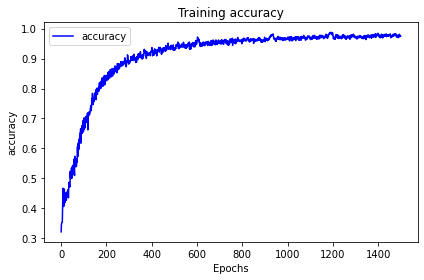

In [ ]:
accuracy_val = training.history['accuracy']
epochs = range(0,epochs_num)
plt.plot(epochs, accuracy_val, 'b', label = 'accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

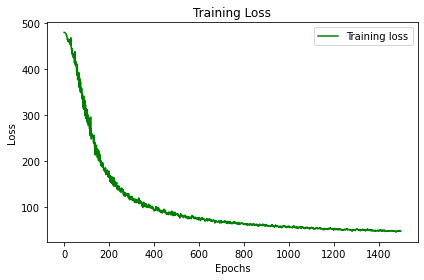

In [ ]:
loss_val = training.history['loss']
epochs = range(0,epochs_num)
plt.plot(epochs, loss_val, 'g', label = 'Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_1=model.predict(X_test)
print(Y_test)


250/250 [==============================] - 4s 13ms/step
tf.Tensor(
[[  175.45488269  -312.24825509   248.67965262]
 [ -130.3185238   -870.06107125    82.55018478]
 [-1215.92225982   623.57512986   104.01856689]
 ...
 [  503.18827028  -321.95749995   -24.63040249]
 [  -84.8684566     19.140179    -413.38559549]
 [  457.93190036  1415.76732379   397.44901542]], shape=(8000, 3), dtype=float64)


In [ ]:
print(y_1)
print(len(y_1))

[[  274.15555   -374.7184     130.90652 ]
 [ -274.10208   -765.0293    -116.01705 ]
 [-1054.1302     713.9544    -152.94286 ]
 ...
 [  422.15875   -119.07322    210.59822 ]
 [  -98.19802     26.913206  -377.9588  ]
 [  627.7579    1337.1726     385.51892 ]]
8000


In [ ]:
import os
DH_dataset_2 = pd.read_csv("output_1.csv")

path = os.path.abspath("output_1.csv")
directory = os.path.dirname(path)

print(directory)

C:\Users\alexi\My Drive\Metrology\2022 Proyectos de Inteligencia Artificial CENAM


In [ ]:
# Save a model using the HDF5 format
model.save("best_model_HDF5_format.h5") # note the addition of '.h5' on the end

In [ ]:
# Load a model from the HDF5 format
loaded_h5_model = tf.keras.models.load_model("best_model_HDF5_format.h5")
loaded_h5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 360)               2520      
                                                                 
 dense_1 (Dense)             (None, 360)               129960    
                                                                 
 dense_2 (Dense)             (None, 360)               129960    
                                                                 
 dense_3 (Dense)             (None, 360)               129960    
                                                                 
 dense_4 (Dense)             (None, 360)               129960    
                                                                 
 dense_5 (Dense)             (None, 360)               129960    
                                                                 
 dense_6 (Dense)             (None, 360)               1